In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from dolfin import *
import math
import numpy as np
import logging
from unconstrainedMinimization import InexactNewtonCG

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)


# Set the level of noise:
noise_std_dev = .3

# Load the image from file
data = np.loadtxt('image.dat', delimiter=',')
np.random.seed(seed=1)
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])

# Set up the domain and the finite element space.
Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.

mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),200, 100)
V = FunctionSpace(mesh, "Lagrange",1)

# Generate the true image (u_true) and the noisy data (u_0)
class Image(Expression):
    def __init__(self, Lx, Ly, data, **kwargs):
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]

trueImage = Image(Lx,Ly,data, degree=1)
noisyImage = Image(Lx,Ly,data+noise, degree=1)
u_true  = interpolate(trueImage, V)
u_0 = interpolate(noisyImage, V)

plt.figure(figsize=[12,24])
plt.subplot(1,2,1)
plot(u_true, title="True Image")
plt.subplot(1,2,2)
plot(u_0, title="Noisy Image")
plt.show()


ImportError: No module named matplotlib.pyplot

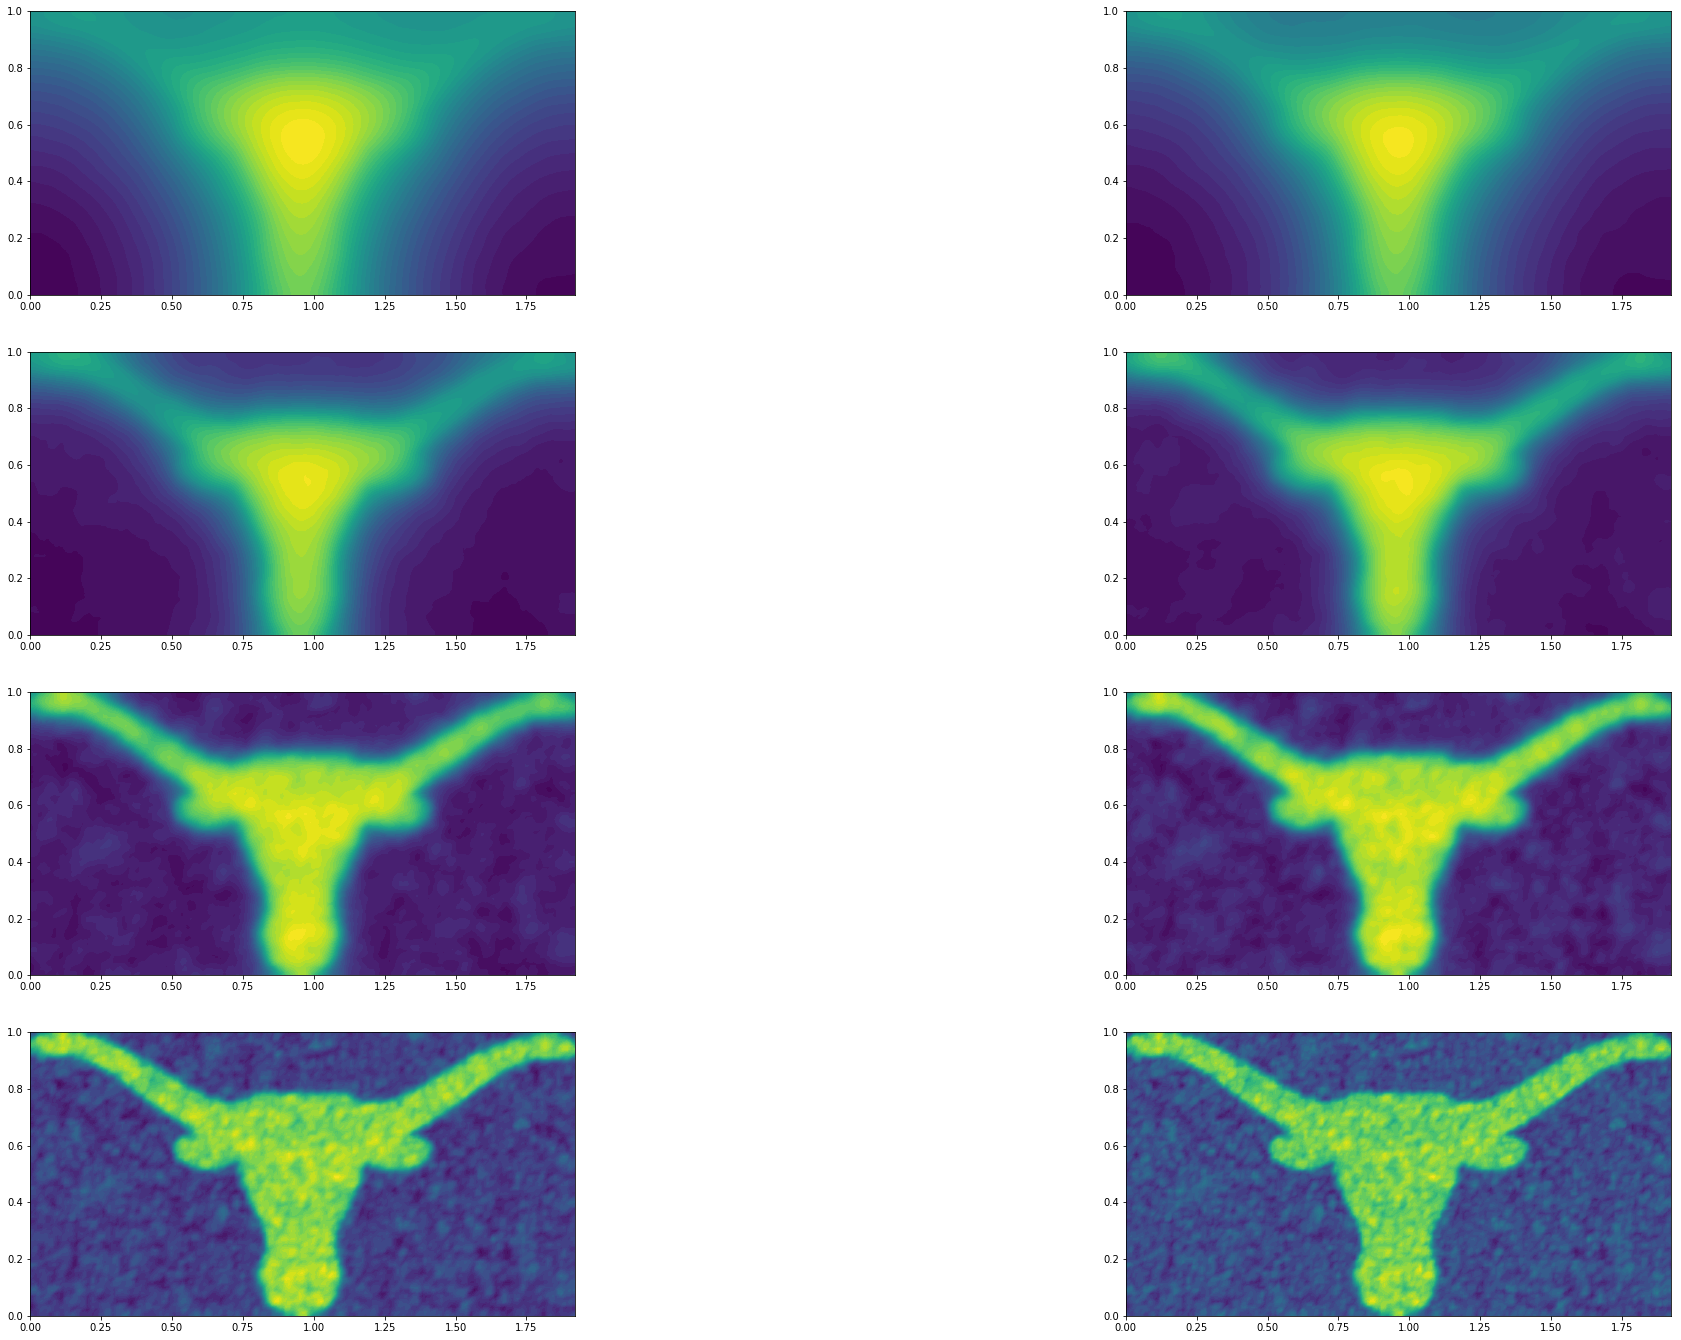

In [63]:
import numpy as np
import numpy.linalg as na

alpha = [.1,.05,.01,.005,.001,.0005]
l = len(alpha)
err = np.zeros(l)
plt.figure(figsize=[36,24])
for i in range(l):
    k = alpha[i]
    u = TrialFunction(V)
    v = TestFunction(V)
    a = (u*v+k*dot(grad(u),grad(v)))*dx
    L = u_0*v*dx

    A,b = assemble_system(a,L)
    usol = Function(V)
    solve(A,usol.vector(),b)
    
    err[i] = errornorm(usol,u_true,'l2')
    plt.subplot(l/2,2,i+1)
    plot(usol)
plt.show()
print(err)

In [1]:
k = .0001
eps = .01
u = Function(V)
u_hat = TestFunction(V)
u_tilde = TrialFunction(V)

E = Constant(.5)*((u-u_0)*(u-u_0)+k*sqrt(inner(nabla_grad(u),nabla_grad(u))+eps))*dx

grad = (u*u_hat-u_hat*u_0 + k*inner(nabla_grad(u),nabla_grad(u_hat))\
        /sqrt(inner(nabla_grad(u),nabla_grad(u)) + eps))*dx
        
H = (u_tilde*u_hat+k*inner(nabla_grad(u_tilde),nabla_grad(u_hat))\
     /sqrt(inner(nabla_grad(u),nabla_grad(u))+eps)-\
     inner(nabla_grad(u),nabla_grad(u_hat))*\
     inner(nabla_grad(u),nabla_grad(u_tilde))/\
     pow((inner(nabla_grad(u),nabla_grad(u))+eps),1.5))*dx

solver = InexactNewtonCG()
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-9
solver.parameters["gdu_tolerance"] = 1e-18
solver.parameters["max_iter"] = 5000
solver.parameters["c_armijo"] = 1e-5
solver.parameters["print_level"] = 1
solver.parameters["max_backtracking_iter"] = 10

solver.solve(E, u, grad, H)

plot(u)
plt.show()
# Hold plot
interactive()

NameError: name 'Function' is not defined